In [65]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import cdecimal as dec


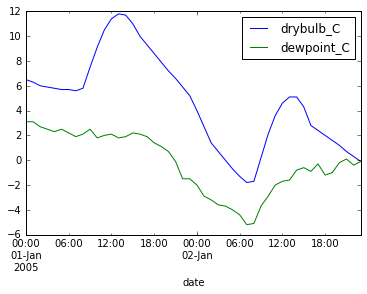

In [3]:
#epw_reader adapted from https://github.com/architecture-building-systems/CEAforArcGIS/blob/master/cea/utilities/epwreader.py

epw_labels = ['year', 'month', 'day', 'hour', 'minute', 'datasource', 'drybulb_C', 'dewpoint_C', 'relhum_percent',
                   'atmos_Pa', 'exthorrad_Whm2', 'extdirrad_Whm2', 'horirsky_Whm2', 'glohorrad_Whm2',
                   'dirnorrad_Whm2', 'difhorrad_Whm2', 'glohorillum_lux', 'dirnorillum_lux','difhorillum_lux',
                   'zenlum_lux', 'winddir_deg', 'windspd_ms', 'totskycvr_tenths', 'opaqskycvr_tenths', 'visibility_km',
                   'ceiling_hgt_m', 'presweathobs', 'presweathcodes', 'precip_wtr_mm', 'aerosol_opt_thousandths',
                   'snowdepth_cm', 'days_last_snow', 'Albedo', 'liq_precip_depth_mm', 'liq_precip_rate_Hour']

weather_path = 'C:\Users\Zghiru\Documents\GitHub\RC_BuildingSimulator\Justin_Semseter_Project\data\CH_ZH_original.epw'
    
def get_full_date(weather_path,month,day):
    year = pd.read_csv(weather_path, skiprows=8, header=None, names=epw_labels)['year']
    return pd.datetime(year[1],month,day)
    

def epw_reader(weather_path):
    start = get_full_date(weather_path,1,1)
    result = pd.read_csv(weather_path, skiprows=8, header=None, names=epw_labels).drop('datasource', axis=1)
    result['dayofyear'] = pd.date_range(start, periods=8760, freq='H').dayofyear  
    result['date'] = pd.date_range(start, periods=8760, freq='H')
    result['ratio_diffhout'] = result['difhorrad_Whm2']/result['glohorrad_Whm2']
    result['index'] = result.index
    return result


#extract column(s) from weather file for a range of days
def get_epw_data(start,end,field = []): 

    start += ' 00:00:00'
    end += ' 23:00:00'
    field.append('index')
    field.insert(0,'date')
    
    series = epw_reader(weather_path=weather_path)  
    series = series.set_index(['date'],drop=False)  
    series = series[start:end][field]
    series = series.set_index(['index']) 
    
    return series 


#Simple Plot
import matplotlib.pyplot as plt

start = '01/01/2005'
end =  '01/02/2005'

field = ['drybulb_C','dewpoint_C']

t = get_epw_data(start,end,field)
t = t.set_index(['date'])

t.plot()
plt.show()




In [113]:
dt = .5 #script needs to be adjusted because it currently truncates data from smaller timesteps to the equivalent length of 1dt

def resample(dt):
    if dt > 1:
        resample_value = str(dt)+'H'
    elif dt < 1:
        resample_value = str(int(dt*60))+'Min'
    elif dt == 1:
        resample_value = '1H'
        
    print resample_value
    
resample(1)
resample(2)

resample(0.3)
resample(0.5)



1H
2H
18Min
30Min


47
                  date  drybulb_C
0  2005-01-01 00:00:00       6.50
1  2005-01-01 00:30:00       6.40
2  2005-01-01 01:00:00       6.30
3  2005-01-01 01:30:00       6.15
4  2005-01-01 02:00:00       6.00
5  2005-01-01 02:30:00       5.95
6  2005-01-01 03:00:00       5.90
7  2005-01-01 03:30:00       5.85
8  2005-01-01 04:00:00       5.80
9  2005-01-01 04:30:00       5.75
10 2005-01-01 05:00:00       5.70
11 2005-01-01 05:30:00       5.70
12 2005-01-01 06:00:00       5.70
13 2005-01-01 06:30:00       5.65
14 2005-01-01 07:00:00       5.60
15 2005-01-01 07:30:00       5.70
16 2005-01-01 08:00:00       5.80
17 2005-01-01 08:30:00       6.65
18 2005-01-01 09:00:00       7.50
19 2005-01-01 09:30:00       8.30
20 2005-01-01 10:00:00       9.10
21 2005-01-01 10:30:00       9.80
22 2005-01-01 11:00:00      10.50
23 2005-01-01 11:30:00      10.95
24 2005-01-01 12:00:00      11.40
25 2005-01-01 12:30:00      11.60
26 2005-01-01 13:00:00      11.80
27 2005-01-01 13:30:00      11.75
28 2005-01-

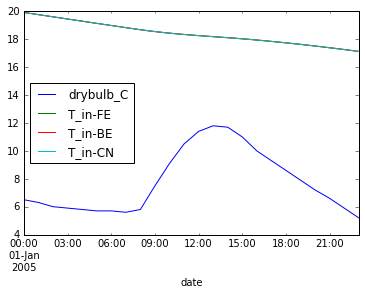

                     drybulb_C    T_in-FE    T_in-BE    T_in-CN
date                                                           
2005-01-01 00:00:00       6.50  19.922360  19.922804  19.922583
2005-01-01 00:30:00       6.40  19.844592  19.845478  19.845036
2005-01-01 01:00:00       6.30  19.766696  19.768022  19.767361
2005-01-01 01:30:00       6.15  19.688385  19.690152  19.689271
2005-01-01 02:00:00       6.00  19.609662  19.611868  19.610768
2005-01-01 02:30:00       5.95  19.531104  19.533747  19.532429
2005-01-01 03:00:00       5.90  19.452710  19.455786  19.454253
2005-01-01 03:30:00       5.85  19.374479  19.377986  19.376238
2005-01-01 04:00:00       5.80  19.296411  19.300344  19.298383
2005-01-01 04:30:00       5.75  19.218505  19.222860  19.220689
2005-01-01 05:00:00       5.70  19.140759  19.145534  19.143153
2005-01-01 05:30:00       5.70  19.063460  19.068649  19.066062
2005-01-01 06:00:00       5.70  18.986605  18.992205  18.989413
2005-01-01 06:30:00       5.65  18.90990

In [150]:
"""
Input data
Adapted from https://github.com/architecture-building-systems/RC_BuildingSimulator/blob/master/simulator/BuildingProperties.py
"""

class building(object): 
    def __init__(self, 
                 R_env = 42,   #resistance of envelope
                 Cm    = 2.07   #capacitance of envelope
                ):
        #Single Capacitance Model Parameters
        self.Cm=Cm #[kWh/K] Room Capacitance. Default based of Madsen2011
        self.R_env=R_env #[K/kW] Wall resistance to outside air. Default based off glass having a Uvalue of 1.978W/m2K, 12m2 facade glass
        
"""
main
"""
def resample(dataframe,dt):
    if dt > 1:
        resample_value = str(dt)+'H'
    elif dt < 1:
        resample_value = str(int(dt*60))+'Min'     
    elif dt == 1:
        resample_value = '1H'
    dataframe = dataframe.set_index(['date']) #use date as index. this allows for time resampling
    dataframe = dataframe.resample(resample_value).mean()  
    dataframe = dataframe.interpolate()   
    dataframe = dataframe.reset_index(drop=False)     
    return dataframe

#Simulation parameters
start = '1/1/2005'
end = '1/1/2005'

#import data
temperatures = get_epw_data(start,end,['drybulb_C'])
T_out = temperatures['drybulb_C']
box = building(Cm = 2.07,R_env = 42)

#initialize conditions
dt = 0.5
temperatures = resample(temperatures,dt)
T_out = temperatures['drybulb_C']


steps = len(temperatures.index)
print steps
print temperatures

T_in_init = 20 #initial internal temperature
Data_Tin = []

#no heating or cooling, no internal gains, no external gains.

#differential equation parameters


#Forward Euler discretization
def FE(T_in,dt): #takes initial internal temperature as input
    Data_Tin = []
    for i in range(0,steps):
        T_in = ((T_out[i]-T_in)/(box.R_env*box.Cm))*dt + T_in
        Data_Tin.append(T_in)
    return Data_Tin

#Backward Euler discretization
def BE(T_in,dt): #takes initial internal temperature as input
    Data_Tin = []
    for i in range(0,steps):
        T_in = ((T_out[i]*dt)+(box.R_env*box.Cm*T_in))/(box.R_env*box.Cm + dt)
        Data_Tin.append(T_in)
    return Data_Tin

#Crank Nicholson discretization
def CN(T_in,dt): #takes initial internal temperature as input
    Data_Tin = []
    for i in range(0,steps):     
        T_in = ((2*T_out[i]*dt)+T_in*(2*box.R_env*box.Cm - dt))/(2*box.R_env*box.Cm +dt)
        Data_Tin.append(T_in)            
    return Data_Tin

"""
x= pd.Series(FE(T_in_init,dt))
x.plot()
plt.show
print x
"""



temperatures['T_in-FE'] = pd.Series(FE(T_in_init,dt))
temperatures['T_in-BE'] = pd.Series(BE(T_in_init,dt))
temperatures['T_in-CN'] = pd.Series(CN(T_in_init,dt))

temperatures = temperatures.set_index(['date'])


temperatures.plot()
plt.show()
print temperatures




Abbreviations

T_out: External temperature in C extracted from an EPW weather file

T_in: Calculated internal temperature

R_env: Resistance of the envelope. Must be caluclated by hand and inputted into the Building class in BuildingProperties.py

R_infl: Equivalent resistance due to infiltration. This is calculated within BuildingProperties.py

R_vent: Equivalent resistance due to ventelation. A variable resistance calculated by the setVentelation method in within the Building class of BuildingProperties.py

Cm: Capacitance of the room. Must be caluclated by hand and inputted into the Building class in BuildingProperties.py

Q_Heat: Heat energy supplied or removed by the heater or cooler. This is determined through a controller based on the temperature set points

Q_rad: Heat energy to the sun. Hourly radiation data through the windows must be determined in advance and read through the read_transmittedR funtion of input_data.py

Q_gains: Internal heat gains of people. Determined through the occupancy profile which is read in through the read_occupancy function of input_data.py